# HTRC-EF CliFi Analysis

**Summary:**
This notebook analyzes cli-fi (climate fiction) texts using HTRC Extracted Features, focusing on environmental themes, literary patterns, and comparative analysis.

# Using Extracted Features to topic model with HTRC FeatureReader and Gensim
This notebook will introduce [HTRC Extracted Features](https://wiki.htrc.illinois.edu/x/kYC2B) files, the [HTRC FeatureReader](https://github.com/htrc/htrc-feature-reader) Python library, and demo how EF files can be used to topic model a workset (collection) of volumes using [Gensim](https://radimrehurek.com/gensim/). This can be helpful both as exploratory data analysis, since anyone can download EF files whenever they'd like, as well as more robust analysis, as Gensim is a powerful topic modeling/machine learning library. This notebook will introduce a few new functions to reformat EF files to a format that can be fed directly into a topic modeling library, such as Gensim or MALLET, as well as some very entry-level visualization of our generated topics using [pyLDAvis](https://github.com/bmabey/pyLDAvis).

Google Colaboratory (Colab) comes with a number of Python libraries built-in, but there are a few it doesn't have. These we will install directly on our Google server that runs this notebook, using `pip` a command line Python package manager.

**NOTE: There will be a warning after running this cell that produces a "restart runtime" button. Do not worry about the warning, however, you will need to click on the button for the rest of the code in the notebook to work.**

In [ ]:
%pip install htrc-feature-reader

In [ ]:
%pip install nltk

In [ ]:
%pip install numpy

Found existing installation: numpy 1.25.1
Uninstalling numpy-1.25.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-7a851222.3.23.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.1


In [4]:
!pip install numpy

  Using cached numpy-1.25.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


First, as almost always with a Jupyter notebook, we'll import the libraries that we'll be using. We need to do this in order to tell Python which libraries have the commands/methods we'll be using:

In [5]:
import pandas as pd
from htrc_features import FeatureReader, Volume
from tqdm.notebook import trange, tqdm
import os
import shutil
import nltk
import gensim

# Because some of our libraries will throw many, many warnings for future changes to their code:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

We've imported:
- [Pandas](https://pandas.pydata.org/) a common library for working with large data, especially text data, while doing data science-y things.
- the HTRC FeatureReader, a specialty Python library for working with EF files.
- [TQDM](https://pypi.org/project/tqdm/) a library that allows for quick and easy progress bars for longer computational tasks.
- `NLTK`, the [Natural Language Toolkit](https://www.nltk.org/)
- Two built-in Python libraries, `shutil` and `os` which help us deal with files and file systems

You can think of importing libraries as basically getting our tools into our workspace, because we know that for some tasks we'll need a screwdriver and for others we may need some duct tape or a drill.


## Working with Volumes

We'll first use the FeatureReader to quickly take a look at EF data. The HTRC FeatureReader is a Python library that was written to make working with the EF files, especially for exploratory analysis, easier. The FeatureReader library aggregates information at a collection and volume level, and also has functions/methods at both levels. For this notebook, we'll be using the EF data at the volume level, though iterating through multiple volumes.

When using the FeatureReader, the first step is usually to create a `Volume` object out of one EF file. We're going to do this by giving the method `Volume()` a HathiTrust ID (HTID), but, if we had a lot of volumes we wanted to look at EF data for, we could also give it a file path to an EF file we already downloaded to our own computer:

In [6]:
test_vol = Volume('mdp.39015067702061')
print(f"{test_vol.title}, by {test_vol.author}, {test_vol.pub_date}, {test_vol.id}")

The raw shark texts /, by ['Hall, Steven, 1975-'], 2007, mdp.39015067702061


Above we see that we created a FeatureReader `Volume` and we use a few built-in methods for a `Volume` to return metadata about the book--author, title, pub date, and HTID. This metadata is bibliographic, and was assigned by a librarian or cataloger at the institution that submitted the item to HathiTrust. This is handy because it can be used as ground truth for machine learning tasks as well as used during the text analysis pipe line, such as for de-duplicating volumes. There are more metadata fields available than above, and you can see all the options by typing `test_vol.` below then hitting `Tab`, which will trigger a pop-up menu listing the possible methods available. See some samples and explore other fields below:

In [7]:
# returns HT record number (which can help with de-duplicating)
print(test_vol.oclc)

# returns publisher information for the volume
print(test_vol.publisher)

# returns a code for the institution that submitted the item to HathiTrust
print(test_vol.source_institution)

# EXPLORE OTHER AVAILABLE METHODS/FIELDS
print(test_vol.date_created)
print(test_vol.genre)

test_vol

94193868
Canongate
MIU
20200209
['document (computer)', 'fiction', 'urn:uuid:b3e086d0-76cf-4903-91d3-00ce2ae38d4e', 'urn:uuid:35f65838-b7f8-40c2-a00e-d8788abe5150']


Some of the methods that pop-up in the above cell are more complex than just returning metadata fields in the file. Some of the methods will instead return new Pandas DataFrames (basically big, interactive tables of data that we'll be using a lot today) with information. For example, we can use `test_vol.begin_line_chars()` to return a DataFrame of the characters that start each line on a given page. Explore some of the other options in the cell below by commenting or un-commenting the code lines (by adding/removing a `#` in front of the line):

In [ ]:
# returns a DataFrame (DF) with begin-line characters for each page
# test_vol.begin_line_chars()

# returns a DF with line counts for each page
# test_vol.line_counts()

# returns a DF with empty line counts for each page
# test_vol.empty_line_counts()

# EXPLORE OTHER METHODS!




Beyond just generating these DataFrames, we can also plot many of them very quickly, which helps us better visualize a large amount of data. For instance, if we wondered about the textual structure of our volume, we may use `.tokens_per_page()` to visualize how many words are on each page of our volume, and see if there is anything interesting:

<Axes: xlabel='page'>

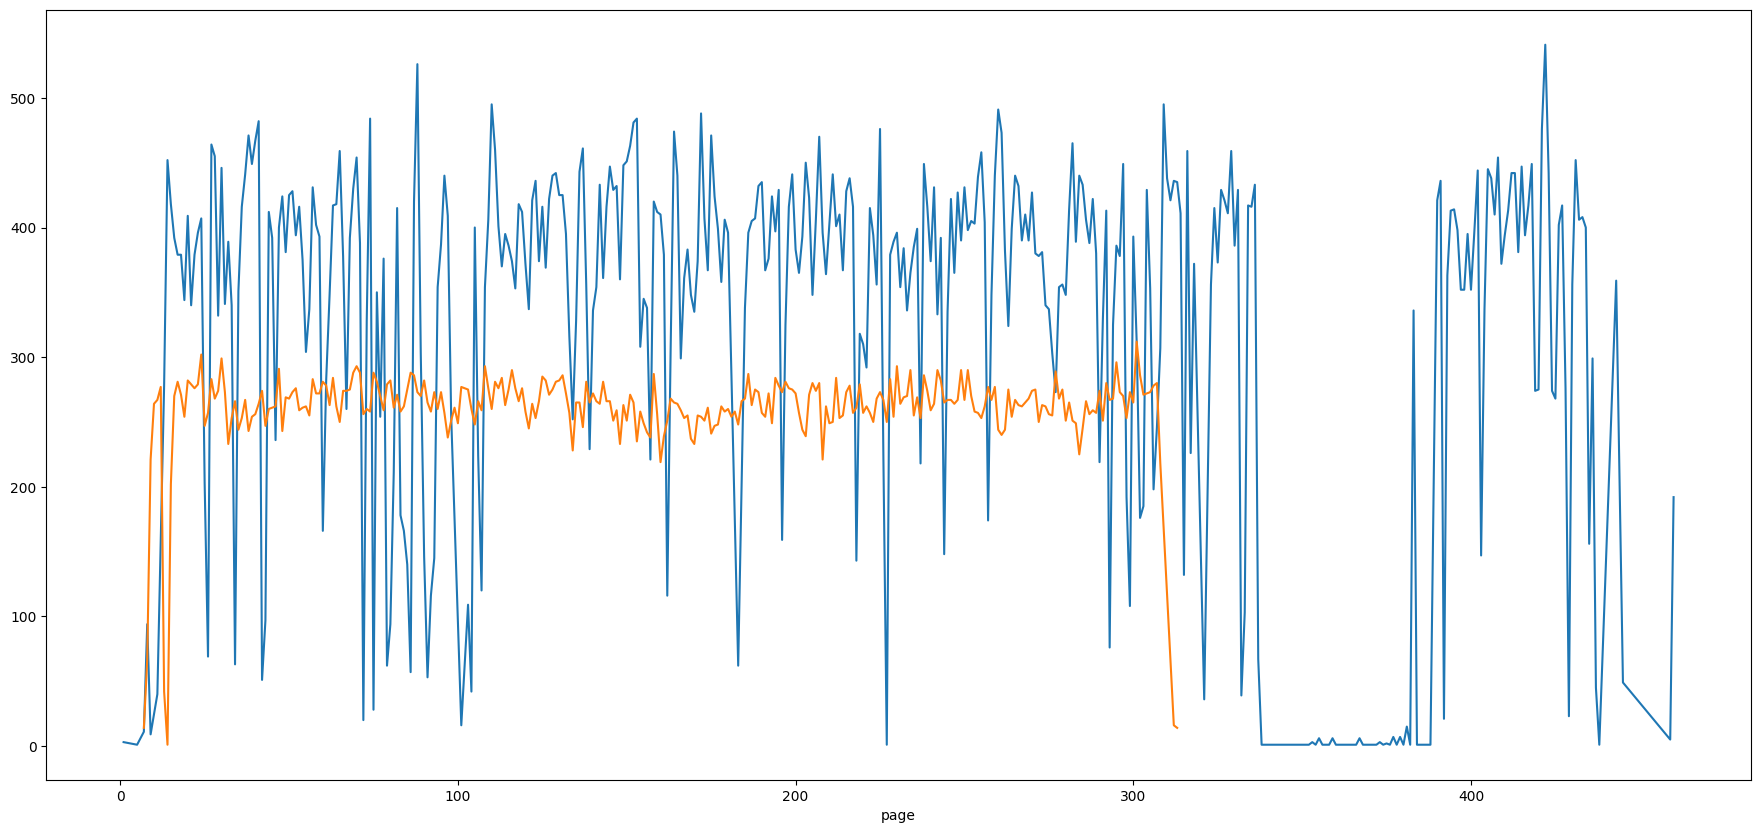

In [ ]:
tkns_df = test_vol.tokens_per_page()
tkns_df.plot(figsize=(22,10))
# tkns_df.head()

# if you want to compare to another volume, here is code for looking at Mrs. Dalloway by Virginia Woolf:
md_vol = Volume('mdp.39015002299421')
md_tkns = md_vol.tokens_per_page()
md_tkns.plot(figsize=(22,10))

Anything interesting here?

Similarly, we can use the FeatureReader for more complex exploratory analysis. Maybe we suspect that parts of our volume contained poetry, we may wish to see if there are any perceivable increases or decrease of capitalized begin line characters in our volume. We could check this with the FeatureReader and a handful of lines of code:

In [8]:
# Create a new Volume from one anthology of Harper's Weekly, a publication known to publish both prose and poetry:
blc_test_vol = Volume('coo.31924054824473')

In [ ]:
# create a DF with begin line characters only:
blc_df = blc_test_vol.begin_line_chars()
# blc_df.head(10)

In [ ]:
# make a new DF with only capitalized alphabetic begin line characters, by page:
caps_blc_df = blc_df.loc[(slice(None), slice(None), slice(None), ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'],)]

# plot the above df!
caps_blc_df.plot(figsize=(20,10))

NameError: ignored

This plot is showing us the counts of capitalized begin line characters per page, and shows spikes around page 240-300, and then later in the volume. This shows where we are likely to have poetry in this volume, and happens to line up with more rigorous poetry-identifying work we've done in [another EF use case](https://wiki.htrc.illinois.edu/x/IQKGAQ).

## Topic Modeling with Token Lists

At this point, you're probably wondering when we'll get to topic modeling using the tokens (words) themselves. Let's not delay any longer and dive in.

Before we topic model, let's look a bit at how we can see and interact with tokens. The most flexible way to do this is to create a token list DataFrame (DF) using the method `vol.token_list()`. This method can be given extra options to get different versions of the data back, and these are called "parameters." Let's take a look at the possible parameters first (maybe learning a handy trick), and then explore a token list. To see the possible parameters for a given function or method, you can type its name as if you were going to run it, but with a `?` instead of parentheses `()`:

In [9]:
test_vol.tokenlist()

tv_pf = test_vol.page_features()
tv_pf.head(25)

,version,calculatedLanguage
page,,
1,727c1cfa1f7b126b03bc2248ff66816c,None
2,628631f07321b22d8c176c200c855e1b,None
3,7215ee9c7d9dc229d2921a40e899ec5f,None
4,d41d8cd98f00b204e9800998ecf8427e,None
5,4b4383cb8a6d27407c9abe7c0d974193,None
6,d41d8cd98f00b204e9800998ecf8427e,None
7,891da2369b0f54561f4a63c17fb98ce1,en
8,90ca3542f8cf86b60e38f6e96bded3c3,en
9,3ef6890fcc6e1c0137f8192aca2db021,en


The above code will not only show us the parameters, but will return the entire Docstring help text for the function, which should not only tell you possible parameters, but also their default values, the data types the function and each parameter takes, the output of the function and even examples of how to use it and what it will return. One thing to keep in mind, though, is that this info is submitted by the author of the library, so how thorough or helpful this help text is can vary wildly between libraries!

Ok, with a new trick under our belts, let's create our first token list to see what info is available. While we do this, we'll also assign the output of `.tokenlist()` to a variable and use `.head()` to look at the first 5 rows of data, since we know the output of `.tokenlist()` is a DataFrame:

In [10]:
test_df = test_vol.tokenlist()
test_df.head(150)

count
page section token     pos       
1    body    HALL      UNK      1
             STEVEN    UNK      1
             TEXTS     UNK      1
5    body    TEXTS     UNK      1
7    body    '         POS      2
...                           ...
13   body    Relic     NN       1
             Slowly    RB       1
             Snot      NNP      1
             Something NN       1
             Static    JJ       1

[150 rows x 1 columns]

In [26]:
tokens.reset_index()


,page,section,token,pos,count
0,460,body,'ll,MD,1
1,460,body,'m,VBP,1
2,460,body,'s,POS,1
3,460,body,'s,VBZ,3
4,460,body,",",",",7
...,...,...,...,...,...
117,460,body,yellow,JJ,1
118,460,body,yet,RB,1
119,460,body,you,PRP,5
120,460,body,your,PRP$,1


In [41]:
page_tokens = []
pages = []

for page in test_vol.pages():
  tokens_df = page.tokenlist()
  tokens_df = tokens_df.reset_index()
  tokens = tokens_df['token'].tolist
  page = tokens_df['page'].tolist
  page_tokens.append(tokens)
  pages.append(page)


Since we looked at an EF file, this data should look familiar, but the structure has been flattened a bit to fit into a DataFrame, which can make it easier to read to our human (hopefully!) eyes. Another interesting thing to note is that the DataFrame returned by `.tokenlist()` has a multi-index. This means that more columns than just a hidden numerical index are treated like an index--that is, you can easily search those levels of data for certain values.This is why we could use `.loc` to quickly find certain letters in our capitalized begin line character example above. This is a powerful way to find certain tokens or parts-of-speech or to do so on specific pages or sections of a volume, though we won't demo that here.

Instead, let's turn directly to using Extracted Features files to topic model our data. Right now, we can get the tokens for each page in a given HathiTrust volume in a highly structured format, a token list. Most topic modeling tools simply want the tokens for each volume/document/page in bag-of-words format. You can think of the bag-of-words format exactly as it sounds:

![](https://drive.google.com/uc?export=view&id=1LHus0vtaiKxKIBIyimtSJOjvqaH4O6Oi)

We take each word from a passage of text, drop it in a "bag" where it loses its original order but still represents the explicit pieces of the original text. Topic modeling is based on co-occurrence between words and word occurrence at the document and topic level, which is why the original semantic structure of the text is irrelevant.

In order to convert EF files to bag-of-words text, we need to write a bit of custom code. We'll define a new function that will parse EF files, grab the tokens for each page and volume and add them to a large DataFrame that will have bag-of-words tokens as one of its columns, along with HTID and page number and a few others. We call this function `ef_vol_to_bow_df` and it takes a FeatureReader `Volume` as an input as well as an optional parameter to save the DataFrame to a TSV. Since this function takes one volume as an input, we'll need to wrap it in some iteration code in order to reformat multiple volumes. Here is the function:

In [ ]:
def ef_file_to_vol_df(htid_filepath_l: list, print_statements=False):
    from htrc_features import FeatureReader, Volume
    import pandas as pd
    from urllib.error import HTTPError
    from tqdm.notebook import trange, tqdm
    import os
    import sys
    import glob
    import string
    import re

    sys.tracebacklimit = None
    cwd = os.getcwd()
    # creating an empty Dataframe to which we'll add clean tokens for each vol, one vol per row
    wkst_df = pd.DataFrame(columns=['htid', 'tokens'])

    n = 0
    error_l = []

    wkst_toks = []

    for ef_filepath in tqdm(htid_filepath_l, total=len(htid_filepath_l)):
        htid = ef_filepath
        htid = ef_filepath.split('/')[-1]
        htid = htid.split('.json.bz2')[0]
        #print(htid)
        #try:
            #vol = Volume(path=ef_filepath)

        try:
            vol = Volume(ef_filepath)

        except Exception as e:
        # Handle the Volume initialization error and skip the file
          print(f"Error processing file: {ef_filepath}. Error: {str(e)}")
          continue

        if vol.tokenlist().empty == True:
            error_e = f"EF file {htid} is empty."
            # print(error_e)
            error_l.append(error_e)
            continue

        else:
            vol_df = vol.tokenlist(section='all', case=False, pos=False, drop_section=True, pages=False)
            vol_df = vol_df.reset_index()
            # print(vol_df.head())
            tkn_list = []

            # should turn this into a function. also should use lambda or apply
            for i in vol_df.itertuples(index=False):
                tkn = str(i.lowercase)
                # print(tkn)
                # print(type(tkn))
                count = i.count
                # print(tkn)
                clean_tkn = tkn.strip()
                # print(type(clean_tkn))
                tkns = ([f'{clean_tkn}'] * count)
                clean_tkn_list = [str(word) for word in tkns if word.isalnum()]
                #Remove punctuation
                clean_tkn_list = [str(word) for word in clean_tkn_list if word not in string.punctuation]
                #Remove stopwords
                clean_tkn_list = [str(word) for word in clean_tkn_list if word not in en_stop]
                #Remove numbers
                clean_tkn_list = [str(word) for word in clean_tkn_list if not re.match(r'\d+', word)]
                # print(clean_tkn_list[:9])
                tkn_list.extend(clean_tkn_list)

            vol_toks = {'htid': htid, 'tokens': tkn_list}
            #vol_toks_df = pd.DataFrame(vol_toks)
            #print(vol_toks_df)
            wkst_toks.append(vol_toks)

        wkst_df = pd.DataFrame(wkst_toks)

    with open('3_errors_text.txt', 'w') as f:
            f.write("\n".join(error_l))

    print(f"{n} volumes missing from EF Dataset")
    print(wkst_df.head())

    return wkst_df

Before we run this function to test it out, we will download a standard set of stop words--the words we want to remove from the text before analysis--and decide if we want to add any additional words to this list. For this workshop, we've built removing stop words into the function that readies EF files for topic modeling. We'll use the standard English stop words from the Natural Language Toolkit (`nltk`) to start with. We have cheated (by running this already) to find that we should make some additions, which we'll do using `.add()` the syntax for adding items to a `Set` (a `Set` is basically a list, but where every item in it is unique and with some extra properties):

In [ ]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

stop_words_to_add = ["'",'"',' ','would','could','should','also', 'said']

for word in stop_words_to_add:
    en_stop.add(word)

#en_stop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


With a list of stop words defined, we can write a few lines of code to iteratively deploy it and test the results. We'll first use three HTIDs for test volumes (the first three books of George RR Martin's *A Song of Ice and Fire* series) and then create a `for` loop to run our `ef_vol_to_bow_pages` function over all three volumes:

In [ ]:
volume_list = ['mdp.39015050507618','ppt.ssfcbz201710000323','mdp.39015054095784']

wkst_df = ef_file_to_vol_df(volume_list)

  0%|          | 0/3 [00:00<?, ?it/s]

ERROR:root:HTTP Error accessing http://data.analytics.hathitrust.org/features-2020.03/ppt/sc2703/ppt.ssfcbz201710000323.json.bz2
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/htrc_features/caching.py", line 73, in open
    fout = super().open(id, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/htrc_features/resolvers.py", line 121, in open
    uncompressed = self._open(id = id, suffix = suffix, mode = mode, format = format,
  File "/usr/local/lib/python3.10/dist-packages/htrc_features/resolvers.py", line 203, in _open
    return Path(dir, filename).open(mode = mode)
  File "/usr/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ppt.ssfcbz201710000323.json.bz2'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/

Error processing file: ppt.ssfcbz201710000323. Error: HTTP Error 404: Not Found
0 volumes missing from EF Dataset
                 htid                                             tokens
0  mdp.39015050507618  [a1, aback, aback, aback, aback, aback, abando...
1  mdp.39015054095784  [aaaaah, aaaaahoooooooooooooooooooo, aaaaahooo...


In [ ]:
wkst_df

,htid,tokens
0,mdp.39015050507618,"[a1, aback, aback, aback, aback, aback, abando..."
1,mdp.39015054095784,"[aaaaah, aaaaahoooooooooooooooooooo, aaaaahooo..."


Now try on a larger set of volumes:

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
volume_list = list(uploaded.values())[0].decode().splitlines()
volume_list[:10]

['nnc1.0315131394',
 'uc2.ark:/13960/t6n011p3j',
 'coo.31924003100207',
 'uc2.ark:/13960/t16m39m6z',
 'mdp.39015007047585',
 'njp.32101068164175',
 'uiuo.ark:/13960/t44q88r9x',
 'mdp.39015041983316',
 'mdp.39015078800441',
 'uc1.$b323021']

In [ ]:
wkst_df2 = ef_file_to_vol_df(volume_list)

print(f"Reformatted {len(volume_list)} volumes to bag-of-words pages.")

In [ ]:
wkst_df2

,htid,tokens
0,mdp.39015011054155,"[aa, aalk, aalk, aalk, aalk, ab, abandon, aban..."
1,mdp.39015012120492,"[aa, aa, aalk, aalk, aalk, aalk, abandon, aban..."
2,mdp.39015023453395,"[aa, aalk, aalk, aalk, aalk, abandon, abandone..."
3,uc1.32106002161526,"[aa, aalk, aalk, aalk, aalk, abandon, abandone..."
4,uc1.32106014483108,"[a6tress, abe, able, able, able, able, able, a..."
...,...,...
1882,mdp.39015056668257,"[aback, aback, abandon, abandon, abandoned, ab..."
1883,mdp.39015064901575,"[a329, a329, aback, aback, abandoned, abandone..."
1884,uc1.b4101885,"[abraham, abruptly, abruptly, absolutely, abso..."
1885,mdp.49015002062330,"[absolutely, added, added, added, age, agreed,..."


Things look to have run successfully (hopefully!). Let's check the dimensions (rows, columns) and look at the output DataFrame to verify:

In [50]:
uploaded = files.upload()

NameError: ignored

In [49]:
print(wkst_df.shape)
wkst_df.head(10)

(1, 460)


,"<bound method IndexOpsMixin.tolist of 0 1\n1 1\n2 1\nName: page, dtype: uint64>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of 0 5\nName: page, dtype: uint64>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of 0 7\n1 7\n2 7\n3 7\n4 7\n5 7\n6 7\n7 7\n8 7\n9 7\nName: page, dtype: uint64>","<bound method IndexOpsMixin.tolist of 0 8\n1 8\n2 8\n3 8\n4 8\n ..\n71 8\n72 8\n73 8\n74 8\n75 8\nName: page, Length: 76, dtype: uint64>","<bound method IndexOpsMixin.tolist of 0 9\n1 9\n2 9\n3 9\n4 9\n5 9\n6 9\n7 9\n8 9\nName: page, dtype: uint64>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>",...,"<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of Series([], Name: page, dtype: uint64)>","<bound method IndexOpsMixin.tolist of 0 459\n1 459\n2 459\n3 459\n4 459\nName: page, dtype: uint64>","<bound method IndexOpsMixin.tolist of 0 460\n1 460\n2 460\n3 460\n4 460\n ... \n117 460\n118 460\n119 460\n120 460\n121 460\nName: page, Length: 122, dtype: uint64>"
0,<bound method IndexOpsMixin.tolist of 0 H...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of 0 TEX...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of 0 ...,<bound method IndexOpsMixin.tolist of 0 ...,<bound method IndexOpsMixin.tolist of 0 192...,<bound method IndexOpsMixin.tolist of Series([...,...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of Series([...,<bound method IndexOpsMixin.tolist of 0 390...,<bound method IndexOpsMixin.tolist of 0 ...


In [ ]:
# Function to filter out stopwords from a list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import words
from gensim.utils import simple_preprocess


#Remove stopwords
stop_words = set(stopwords.words("english"))
wkst_df['tokens'] = wkst_df['tokens'].apply(remove_stopwords)
wkst_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,htid,tokens
0,mdp.39015011054155,"[aa, aalk, aalk, aalk, aalk, ab, abandon, aban..."
1,mdp.39015012120492,"[aa, aa, aalk, aalk, aalk, aalk, abandon, aban..."
2,mdp.39015023453395,"[aa, aalk, aalk, aalk, aalk, abandon, abandone..."
3,uc1.32106002161526,"[aa, aalk, aalk, aalk, aalk, abandon, abandone..."
4,uc1.32106014483108,"[a6tress, abe, able, able, able, able, able, a..."
...,...,...
1882,mdp.39015056668257,"[aback, aback, abandon, abandon, abandoned, ab..."
1883,mdp.39015064901575,"[a329, a329, aback, aback, abandoned, abandone..."
1884,uc1.b4101885,"[abraham, abruptly, abruptly, absolutely, abso..."
1885,mdp.49015002062330,"[absolutely, added, added, added, age, agreed,..."


In [ ]:
# Function to filter out nonEnglish words from a list of tokens
def keep_English_only(tokens):
    return [token for token in tokens if token.lower() in my_words]


#Define list of words to keep from nltk words
#Set function will make processing faster
nltk.download('words')
words_list = words.words()
my_words = set(words.words())

#Keep only words in lemma list that are also in words corpus
wkst_df['English_Text'] = wkst_df['tokens'].apply(keep_English_only)
wkst_df

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


,htid,tokens,English_Text
0,mdp.39015011054155,"[aa, aalk, aalk, aalk, aalk, ab, abandon, aban...","[aa, abandon, abandoned, abandoned, abandonmen..."
1,mdp.39015012120492,"[aa, aa, aalk, aalk, aalk, aalk, abandon, aban...","[aa, aa, abandon, abandoned, abandoned, abando..."
2,mdp.39015023453395,"[aa, aalk, aalk, aalk, aalk, abandon, abandone...","[aa, abandon, abandoned, abandoned, abandonmen..."
3,uc1.32106002161526,"[aa, aalk, aalk, aalk, aalk, abandon, abandone...","[aa, abandon, abandoned, abandoned, abandonmen..."
4,uc1.32106014483108,"[a6tress, abe, able, able, able, able, able, a...","[able, able, able, able, able, able, able, abl..."
...,...,...,...
1882,mdp.39015056668257,"[aback, aback, abandon, abandon, abandoned, ab...","[aback, aback, abandon, abandon, abandoned, ab..."
1883,mdp.39015064901575,"[a329, a329, aback, aback, abandoned, abandone...","[aback, aback, abandoned, abandoned, abandoned..."
1884,uc1.b4101885,"[abraham, abruptly, abruptly, absolutely, abso...","[abruptly, abruptly, absolutely, absolutely, a..."
1885,mdp.49015002062330,"[absolutely, added, added, added, age, agreed,...","[absolutely, added, added, added, age, agreed,..."


In [ ]:
#Change to lemmas
#Words corpus does not contain plural forms, must lemmatize first
from nltk import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')
wnl = WordNetLemmatizer()

# Function to lemmatize tokens
def get_lemmas(tokens):
    return [wnl.lemmatize(token) for token in tokens]

#Can choose to lemmatize clean text with or without stopwords
wkst_df['Cleaned_text'] = wkst_df['English_Text'].apply(get_lemmas)
wkst_df

,htid,tokens,English_Text,Cleaned_text
0,mdp.39015011054155,"[aa, aalk, aalk, aalk, aalk, ab, abandon, aban...","[aa, abandon, abandoned, abandoned, abandonmen...","[aa, abandon, abandoned, abandoned, abandonmen..."
1,mdp.39015012120492,"[aa, aa, aalk, aalk, aalk, aalk, abandon, aban...","[aa, aa, abandon, abandoned, abandoned, abando...","[aa, aa, abandon, abandoned, abandoned, abando..."
2,mdp.39015023453395,"[aa, aalk, aalk, aalk, aalk, abandon, abandone...","[aa, abandon, abandoned, abandoned, abandonmen...","[aa, abandon, abandoned, abandoned, abandonmen..."
3,uc1.32106002161526,"[aa, aalk, aalk, aalk, aalk, abandon, abandone...","[aa, abandon, abandoned, abandoned, abandonmen...","[aa, abandon, abandoned, abandoned, abandonmen..."
4,uc1.32106014483108,"[a6tress, abe, able, able, able, able, able, a...","[able, able, able, able, able, able, able, abl...","[able, able, able, able, able, able, able, abl..."
...,...,...,...,...
1882,mdp.39015056668257,"[aback, aback, abandon, abandon, abandoned, ab...","[aback, aback, abandon, abandon, abandoned, ab...","[aback, aback, abandon, abandon, abandoned, ab..."
1883,mdp.39015064901575,"[a329, a329, aback, aback, abandoned, abandone...","[aback, aback, abandoned, abandoned, abandoned...","[aback, aback, abandoned, abandoned, abandoned..."
1884,uc1.b4101885,"[abraham, abruptly, abruptly, absolutely, abso...","[abruptly, abruptly, absolutely, absolutely, a...","[abruptly, abruptly, absolutely, absolutely, a..."
1885,mdp.49015002062330,"[absolutely, added, added, added, age, agreed,...","[absolutely, added, added, added, age, agreed,...","[absolutely, added, added, added, age, agreed,..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
wkst_df.to_csv('full_scifi_wkst.csv')
files.download("full_scifi_wkst.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The dimensions look right, as does the data in `workset_page_df`.

We can now shift to grabbing the bag-of-words text in the `page_tokens` column and readying it for Gensim. We're using a straightforward, no frills version of topic modeling where we aren't tracking the documents in our collection, and are instead just topic modeling the words. For this, Gensim wants one big list of the tokens, and we'll generate this using another `for` loop:

In [ ]:
bow_text_lists = []
bow_text = []

for i,r in wkst_df.iterrows():
    words = r.tokens
    bow_text_lists.append(words)
    for word in words:
        bow_text.append(word)

print(f"Added {len(bow_text)} words to list.")

Gensim takes "dictionary" and "corpus" objects to train an LDA model. For Gensim, a "dictionary" is a list of the unique tokens in your corpus, assigned to a numerical ID, and a "corpus" is your complete bag-of-words data--the list of words we just created, `bow_text`--but represented by the numerical ID from the "dictionary" and its count. This is a bit confusing, so let's generate both and take a look at them directly. Here is the code to create the dictionary and corpus, pulled from Gensim documentation:

In [ ]:
# importing libraries from Gensim to create corpus and dictionary
from gensim import corpora

# creating our dictionary and corpus
dictionary = corpora.Dictionary(bow_text_lists)
corpus = [dictionary.doc2bow(text) for text in bow_text_lists]

# importing pickle, a library which lets us save our corpus and dictionary for later use
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Here is a look at the first 15 items in our Gensim `dictionary`:

In [ ]:
n = 0

for k,v in dictionary.items():
    if n <= 15:
        print(f"{k} : {v}")
        n += 1

And here is one page of bag-of-words data (represented numerically as `(word ID, count)` pairs or tuples) in our Gensim `corpus`:

In [ ]:
# return item 1 in our corpus:
corpus[1]

With these two inputs created, we can now train and run our topic model, saving the model along the way (again, pulling code from Gensim documentation--you don't have to know how to do this off the top of your head!):

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# THIS CODE WILL TAKE A FEW MINUTES OR SO TO RUN!
number_of_topics = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = number_of_topics, id2word=dictionary, passes=50, random_state=42)
ldamodel.save('model10.gensim')

Three major inputs are adjustable: the number of topics we want to generate, the number of passes we want to do when training our model, and the random state or seed. The number of topics is custom for each set of volumes/documents and is often something that you should test out. Do your results make more or less sense with more or fewer topics? The number of passes will effect the "accuracy" of your topic models. The algorithm is training the topics as many times as you input passes, and then taking an aggregated average of the results. Since there is a random element to topic modeling, results are different for every pass. The more passes we do, the more we can reduce the randomness of the results. Here, we're doing 50 passes, since our data is not too big, but you may find more or less is suitable based on testing out results. Another way to minimize the randomness is to set the seed, or in Gensim the `random_state`. By setting the "seed" or the `random_state` we are saying to eliminate the randomness and always go with the number option we indicate. You can play with this number as well and see how the results change. We have started with 42 because it is the answer to eveything.

Ok, back to results!

Nothing is explicitly returned from the code above, as the model is created and saved, but we can see the topics that were generated using `show_topics()` which also lets us decide how many of the top words for each topic we want to see:

In [ ]:
topics = ldamodel.show_topics(num_words=10, formatted=False)

for topic in topics:
    print(f"{topic} + '\n'")


We can also get all the documents for which a term has an association in our model using Gensim's `get_term_topics` method, which takes a term and a minimum probability and returns each topic for which that term meets the minimum probability of appearing in. We can see all topics for a given term simply by passing `0` to the parameter `minimum_probability`:



In [ ]:
ldamodel.get_term_topics('brave', minimum_probability=0)


While it's very useful to see our topics, the top N terms associated with them, and be able to check topic association for a given term, we may also want to see how each of our documents associates with our topics. We can use Gensim's `get_document_topics` method for this (and remember that a 'document' for us is a page of a HathiTrust volume):

In [ ]:
all_topics = ldamodel.get_document_topics(corpus, per_word_topics=True)
n = 0

for doc_topics, word_topics, phi_values in all_topics[20:25]:
    print(f"Document {n}\n")
    print('Document topics (what topics this document is associated with):')
    print(f"{doc_topics}\n")
    print('Word topics (what topics words in this document are associated with):')
    print(f"{word_topics}\n")
    print('Phi values (probability of a word in this document being associated with a given topic):')
    print(f"{phi_values}\n")
    print('-------------- \n')
    n += 1

We can also Write out the topics and their top n words (here, n=25) to a file with the following code (**Note: this doesn't work in Google Colab**):

In [ ]:
# DOESN'T WORK FOR COLAB, SADLY!
topics = ldamodel.show_topics(num_topics=5, num_words=25)

with open('asoiaf_topics_5.tsv', 'a') as f:
    for topic in topics:
        topic_num = topic[0]
        topic_words = topic[1]
        f.write(f"{topic_num} + '\t' + {topic_words} + '\n'")

Now, with our topic modeling results, the fun begins--interpreting what we see. For this set of books, *A Game of Thrones*, *A Clash of Kings* and *A Storm of Swords*, the results *seem* to make sense, as we see the clustering of characters that interact with each other heavily, as well as thematic elements for those characters and their narrative arcs.

We can use another library called `pyLDAvis` to better visualize our topics, and see if they still make sense:

In [ ]:
# load the dictionary, corpus, and LDA model we created earlier:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

# If you generate a new model and change the number of topics, you may need to change the file name for the model (here, model5.gensim)
lda = gensim.models.ldamodel.LdaModel.load('model100.gensim')

#Create visualization of topic model above
%matplotlib inline
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model2, corpus=corpus, dictionary=dictionary, mds='mmds')
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

pyLDAvis.save_html(vis, 'noveltm_gb')

That's it! You've topic modeled 3 books, tens of thousands of words, using Gensim and HTRC Extracted Features. However, since topic modeling has a random seed, you should continue to explore by tweaking the inputs: stop words, number of topics, passes, and the random seed itself. We could also topic model while retaining the structure of the original pages/documents, or chunking our text into smaller pieces and reviewing how the results might change. Since topic modeling is really great for exploring data, we shouldn't be shy when it comes to experimenting with inputs and data. You'll never know how good results can be until you try different methods of generating them.

**Questions about this notebook?** Contact HTRC at htrc-help@hathitrust.org

CC-BY-NC 4.0 (2021)